---
title: Building Sentinel-2 Data Cubes with xcube EOPF
subtitle: From Multiple EOPF Zarr Tiles to Analysis-Ready Data Cubes (ARDCs)
authors:
  - name: Konstantin Ntokas
    orcid: 0000-0002-0049-0690
    github: konstntokas
    affiliations:
      - id: Brockmann Consult GmbH
        institution: Brockmann Consult GmbH
        ror: 04r0k9g65
reviewers:
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-06-12
thumbnail: ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
keywords: ["data access", "xarray", "EOPF Zarr products"]
tags: ["sentinel-2", "xarray", "xarray-eopf", "xcube-eopf", "stac", "xcube"]
releaseDate: 2025-06-13
datePublished: 2025-06-13
dateModified: 2025-06-13
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of Contents
1. [Introduction](#Introduction_XCUBE_EOPF)
2. [Install the xcube-eopf Data Store](#Install_XCUBE_EOPF)
3. [Introduction to xcube](#Introduction_to_xcube_XCUBE_EOPF)
4. [Main Features of the xcube-eopf Data Store](#Main_Features_XCUBE_EOPF)
5. [Import modules](#Import_XCUBE_EOPF)
6. [Data Store Basics](#Data_store_basics_XCUBE_EOPF)
7. [Open multiple Sentinel-2 samples as anaylsis-ready data cube](#Open_multiple_Sentinel_2_samples_as_anaylsis_ready_data_cube_XCUBE_EOPF)
8. [End-to-End Example: Data Access, Saving, and Visulation](#End_to_End_Example_XCUBE_EOPF)
9. [Conclusion](#Conclusion_XCUBE_EOPF)

(Introduction_XCUBE_EOPF)=
## Introduction

`xcube-eopf` is a Python package and [xcube plugin](https://xcube.readthedocs.io/en/latest/plugins.html) that adds a [data store](https://xcube.readthedocs.io/en/latest/api.html#data-store-framework) named `eopf-zarr` to xcube. The data store is used to provide analysis-ready datacubes (ARDC) from EOPF Sentinel Zarr Samples.

This notebook demonstrates how to use the **xcube-eopf** plugin to explore and analyze EOPF Sentinel-2 Zarr Samples. It highlights the key features currently supported by the plugin.

- 🐙 **GitHub:** [EOPF Sample Service – xcube-eopf](https://github.com/EOPF-Sample-Service/xcube-eopf)  
- ❗ **Issue Tracker:** [Submit or view issues](https://github.com/EOPF-Sample-Service/xcube-eopf/issues)  
- 📘 **Documentation:** [xcube-eopf Docs](https://eopf-sample-service.github.io/xcube-eopf/)

:::{hint} Overview
**Questions**
- How do I install the xcube-eopf data store?
- How can I use the xcube-eopf data store effectively?
- What features does the xcube-eopf data store provide?

**Objectives**
- Learn how to open and work with multiple EOPF Sentinel-2 Zarr samples as analysis-ready datacubes (ARDC).
- Understand the key features and capabilities of the `eopf-zarr` data store.
:::

---

(Install_XCUBE_EOPF)=
## Install the xcube-eopf Data Store

The xcube-eopf package is implemented as a **xcube plugin** and can be installed using either `pip` or `conda/mamba` from the conda-forge channel.

- 📦 **PyPI:** [xcube-eopf on PyPI](https://pypi.org/project/xcube-eopf/)  `pip install xcube-eopf`
- 🐍 **Conda (conda-forge):** [xcube-eopf on Anaconda](https://anaconda.org/conda-forge/xcube-eopf) `conda install -c conda-forge xcube-eopf`

  You can also use **Mamba** as a faster alternative to Conda: `mamba install -c conda-forge xcube-eopf`

---

(Introduction_to_xcube_XCUBE_EOPF)=
## Introduction to xcube

[xcube](https://xcube.readthedocs.io/en/latest/) is an open-source Python toolkit for transforming Earth Observation (EO) data into analysis-ready datacubes following [CF conventions](http://cfconventions.org/cf-conventions/cf-conventions.html). It enables efficient data access, processing, publication, and interactive exploration.

Key components of xcube include:

1. [**xcube data stores**](https://xcube.readthedocs.io/en/latest/dataaccess.html) – efficient access to EO datasets  
2. **xcube data processing** – creation of self-contained analysis-ready datacubes  
3. [**xcube Server**](https://xcube.readthedocs.io/en/latest/webapi.html) – RESTful APIs for managing and serving data cubes  
4. [**xcube Viewer**](https://xcube-dev.github.io/xcube-viewer/build_viewer/#build-and-deploy) – a web app for visualizing and exploring data cubes

### Data Stores

Data stores are implemented as plugins. Once installed, it registers automatically and can be accessed via xcube's `new_data_store()` method. The most important operations of a data store instance `store` are:

- `store.list_data_ids()` - List available data sources.
- `store.has_data(data_id)` - Check data source availability.
- `store.get_open_data_params_schema(data_id)` - View available open parameters for each data source.
- `store.open_data(data_id, **open_params)` - Open a given dataset and return, e.g., an xarray.Dataset instance.

To explore all available functions, see the [Python API](https://eopf-sample-service.github.io/xcube-eopf/api/).

(Main_Features_XCUBE_EOPF)=
## Main Features of the xcube-eopf Data Store

The `xcube-eopf` plugin uses the [`xarray-eopf`](https://eopf-sample-service.github.io/xarray-eopf/) backend to access individual EOPF Zarr samples, then leverages xcube’s data processing capabilities to generate a 3D analysis-ready datacube (ARDCs) from multiple samples.

Currently, this functionality supports **Sentinel-2** products.

The workflow for building datacubes from multiple Sentinel-2 products involves the following steps, which are implemented in the `open_data()` method:


1. **Query** products using the [EOPF STAC API](https://stac.browser.user.eopf.eodc.eu/) for a given time range and 
   spatial extent.
2. **Retrieve** observations as cloud-optimized Zarr chunks via the [xarray-eopf backend](https://eopf-sample-service.github.io/xarray-eopf/) ([Webinar 3](https://zarr.eopf.copernicus.eu/webinars/webinar-3-access-eopf-zarr-products-with-the-new-xarray-eopf-backend/)).
3. **Mosaic** spatial tiles into single images per timestamp.
4. **Stack** the mosaicked scenes along the temporal axis to form a 3D cube.

📚 **More info:** [xcube-eopf Documentation](https://eopf-sample-service.github.io/xcube-eopf/)

---

(Import_XCUBE_EOPF)=
## Import Modules

The `xcube-eopf` data store is implemented as a plugin for `xcube`. Once installed, it registers the store ID `eopf-zarr` automatically and a new data store instance can be initiated via xcube's `new_data_store()` method.

In [1]:
import os

import dask
import xarray as xr
from xcube.core.store import new_data_store
from xcube.util.config import load_configs
from xcube.webapi.viewer import Viewer
from xcube_eopf.utils import reproject_bbox

In [2]:
xr.set_options(display_expand_attrs=False)

In [3]:
store = new_data_store("eopf-zarr")

(Data_store_basics_XCUBE_EOPF)=
## Data Store Basics

The following section introduces the basic functionality of an xcube data store. It helps you navigate the store and identify the appropriate parameters for opening datacubes.

The data IDs point to [STAC collections](https://stac.browser.user.eopf.eodc.eu). So far `'sentinel-2-l1c'` and `'sentinel-2-l2a'` is supported. To list all available data IDs:

In [4]:
store.list_data_ids()

['sentinel-2-l1c', 'sentinel-2-l2a']

One can also check if a data ID is available via the `has_data()` method, as shown below:

In [5]:
store.has_data("sentinel-2-l2a")

True

The Sentinel-1 GRD product is not yet available, so the following cell returns `False`:

In [6]:
store.has_data("sentinel-1-l1-grd")

False

Below, you can view the parameters for the `open_data()` method for each supported data product. The following cell generates a JSON schema that lists all opening parameters for each supported Sentinel product.

In [7]:
store.get_open_data_params_schema()

(Open_multiple_Sentinel_2_samples_as_anaylsis_ready_data_cube_XCUBE_EOPF)=
## Open Multiple Sentinel-2 Samples as an Analysis-Ready Data Cube

Sentinel-2 provides multi-spectral imagery at varying native spatial resolutions:

- **10m**: `b02`, `b03`, `b04`, `b08`  
- **20m**: `b05`, `b06`, `b07`, `b8a`, `b11`, `b12`  
- **60m**: `b01`, `b09`, `b10`

Sentinel-2 products are organized as STAC Items, each representing a single tile. These tiles overlap and are stored in their native UTM coordinate reference system (CRS), which varies by geographic location.

![Sentinel-2 Tiles](sen2_tiles.png)

**Data Cube Generation Workflow**

1. **STAC Query:** A STAC API request returns relevant STAC Items (tiles) based on 
   spatial and temporal extent (`bbox` and `time_range` argument).
2. **Sorting:** Items are ordered by solar acquisition time and Tile ID.
3. **Native Alignment:** Within each UTM zone, tiles from the same solar day are 
   aligned in the native UMT without reprojection. Overlaps are resolved by selecting 
   the first non-NaN pixel value in item order.
4. **Cube Assembly:** The method of cube creation depends on the user's request,
  as summarized below:

| Scenario         | Native Resolution Preservation                                                                                                                                                                                                                                                      | Reprojected or Resampled Cube                                                                                                                                                              |
|------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Condition        | Requested bounding box lies within a single UTM zone, native CRS is requested, and the spatial resolution matches the native resolution.                                                                                                                                            | Data spans multiple UTM zones, a different CRS is requested (e.g., EPSG:4326), or a custom spatial resolution is requested.                                                                |
| Processing steps | Only upsampling or downsampling is applied to align the differing resolutions of the spectral bands. Data cube is directly cropped using the requested bounding box, preserving original pixel values. Spatial extent may deviate slightly due to alignment with native pixel grid. | A target grid mapping is computed from bounding box, spatial resolution, and CRS. Data from each UTM zone is reprojected/resampled to this grid. Overlaps resolved by first non-NaN pixel. |

The `get_open_data_params_schema(data_id)` function can also be used for a specific `data_id`. It provides descriptions of the available opening parameters, including their format and whether they are required.

When calling `open_data(data_id, **open_params)`, the provided parameters are validated against this schema. If they do not match, an error is raised immediately.

In [8]:
store.get_open_data_params_schema(data_id="sentinel-2-l2a")

Below the opening parameters for the Sentinel-2 product (applicable for L1C and L2A) are summarized:

**Required parameters:**

- `bbox`: Bounding box ["west", "south", "est", "north"] in CRS coordinates.
- `time_range`: Temporal extent ["YYYY-MM-DD", "YYYY-MM-DD"].
- `spatial_res`: Spatial resolution in meter of degree (depending on the CRS).
- `crs`: Coordinate reference system (e.g. `"EPSG:4326"`).

These parameters control the STAC API query and define the output cube's spatial grid.

**Optional parameters:**

- `variables`: Variables to include in the dataset. Can be a name or regex pattern 
  or iterable of the latter.
    - Surface reflectance bands: `b01`, `b02`, `b03`, `b04`, `b05`, `b06`, `b07`, `b08`, `b8a`, `b09`, `b11`, `b12`
    - Classification/Quality layers (L2A only): `cld`, `scl`, `snw`
- `tile_size`: Spatial tile size of the returned dataset `(width, height)`.
- `query`: Additional query options for filtering STAC Items by properties. See 
  [STAC Query Extension](https://github.com/stac-api-extensions/query) for details.
- `spline_orders`: governs 2D interpolation; accepts a single order for all variables, or a dictionary mapping orders to variable 
  names or data types; Supported spline orders: 
    - `0`: nearest neighbor (default for `scl`)
    - `1`: linear
    - `2`: bi-linear
    - `3`: cubic (default)
- `agg_methods`: governs the aggregation method during downsampling; accepts a single order for all variables, or a dictionary mapping orders to variable names or data types. Supported spline orders:
    - `"mean"` (default)
    - `"center"` (default for `scl`)
    - `"count"`, `"first"`, `"last"`, `"max"`, `"median"`, `"mode"`, `"min"`, `"prod"`, `"std"`, `"sum"`, `"var"`

---

We now want to generate a small example data cube in native UTM projection from the Sentinel-2 L2A samples:
- Assign `data_id` to `"sentinel-2-l2a"`.
- Set the bounding box to cover Hamburg area.
- Set the time range to the first week of Mai 2025.

In [9]:
bbox = [9.85, 53.5, 10.05, 53.6]
crs_utm = "EPSG:32632"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_utm)

💡 **Note**  
`open_data()` builds a Dask graph and returns a lazy `xarray.Dataset`. No actual data is loaded at this point. 

In [10]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm,
    time_range=["2025-05-01", "2025-05-07"],
    spatial_res=10,
    crs=crs_utm,
    variables=["b02", "b03", "b04", "scl"],
)
ds

CPU times: user 654 ms, sys: 28.3 ms, total: 682 ms
Wall time: 2.69 s


<xarray.Dataset> Size: 114MB
Dimensions:      (time: 3, y: 1132, x: 1341)
Coordinates:
  * time         (time) datetime64[ns] 24B 2025-05-01T10:40:41.025000 ... 202...
    spatial_ref  int64 8B ...
  * x            (x) float64 11kB 5.562e+05 5.563e+05 ... 5.696e+05 5.696e+05
  * y            (y) float64 9kB 5.94e+06 5.94e+06 ... 5.928e+06 5.928e+06
Data variables:
    b02          (time, y, x) float64 36MB dask.array<chunksize=(1, 1132, 1341), meta=np.ndarray>
    b03          (time, y, x) float64 36MB dask.array<chunksize=(1, 1132, 1341), meta=np.ndarray>
    b04          (time, y, x) float64 36MB dask.array<chunksize=(1, 1132, 1341), meta=np.ndarray>
    scl          (time, y, x) uint8 5MB dask.array<chunksize=(1, 1132, 1341), meta=np.ndarray>
Attributes: (4)

We can plot the the red band (`b04`) for the first time step as an example. This operation triggers data downloads and processing.

CPU times: user 231 ms, sys: 72.7 ms, total: 304 ms
Wall time: 450 ms


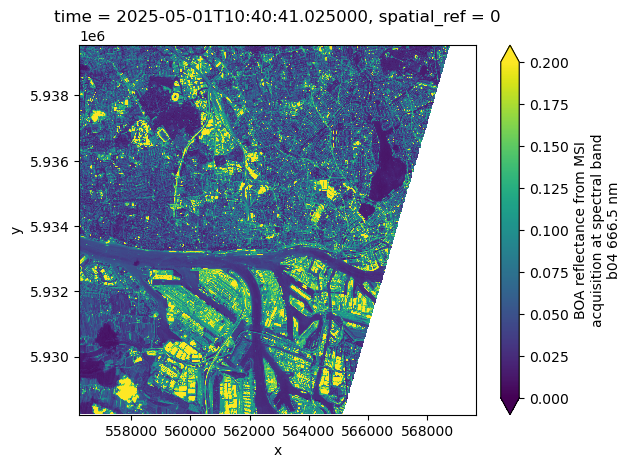

In [11]:
%%time
ds.b04.isel(time=0).plot(vmin=0, vmax=0.2)

Now we can request the same data cube but in geographic projection ("EPSG:4326"). xcube-eopf can reproject the datacube to any projection requested by the user.

In [12]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox,
    time_range=["2025-05-01", "2025-05-07"],
    spatial_res=10 / 111320,  # meters converted to degrees (approx.)
    crs="EPSG:4326",
    variables=["b02", "b03", "b04", "scl"],
)
ds

CPU times: user 859 ms, sys: 27.1 ms, total: 886 ms
Wall time: 3.35 s


<xarray.Dataset> Size: 186MB
Dimensions:      (time: 3, lon: 2228, lat: 1115)
Coordinates:
  * time         (time) datetime64[ns] 24B 2025-05-01T10:40:41.025000 ... 202...
    spatial_ref  int64 8B 0
  * lon          (lon) float64 18kB 9.85 9.85 9.85 9.85 ... 10.05 10.05 10.05
  * lat          (lat) float64 9kB 53.6 53.6 53.6 53.6 ... 53.5 53.5 53.5 53.5
Data variables:
    b02          (time, lat, lon) float64 60MB dask.array<chunksize=(1, 1115, 1830), meta=np.ndarray>
    b03          (time, lat, lon) float64 60MB dask.array<chunksize=(1, 1115, 1830), meta=np.ndarray>
    b04          (time, lat, lon) float64 60MB dask.array<chunksize=(1, 1115, 1830), meta=np.ndarray>
    scl          (time, lat, lon) uint8 7MB dask.array<chunksize=(1, 1115, 1830), meta=np.ndarray>
Attributes: (4)

CPU times: user 897 ms, sys: 99.4 ms, total: 996 ms
Wall time: 967 ms


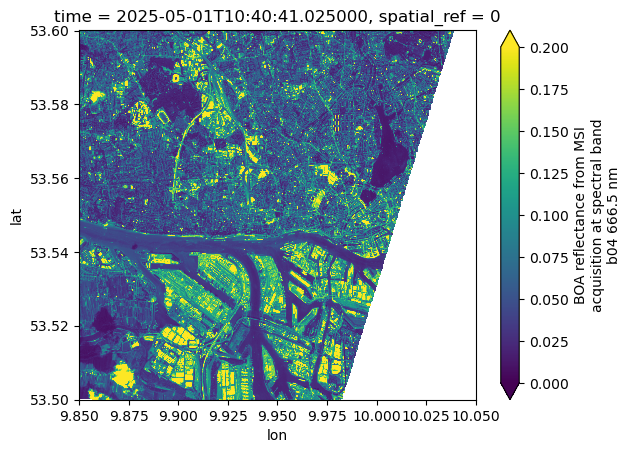

In [13]:
%%time
ds.b04.isel(time=0).plot(vmin=0, vmax=0.2)

We now want to generate a similar data cube from the Sentinel-2 L1C product. We therefore assign `data_id` to `"sentinel-2-l1c"`.

In [14]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l1c",
    bbox=bbox_utm,
    time_range=["2025-05-01", "2025-05-07"],
    spatial_res=10,
    crs=crs_utm,
    variables=["b02", "b03", "b04"],
)
ds

CPU times: user 580 ms, sys: 35 ms, total: 615 ms
Wall time: 2.86 s


<xarray.Dataset> Size: 109MB
Dimensions:      (time: 3, y: 1132, x: 1341)
Coordinates:
  * time         (time) datetime64[ns] 24B 2025-05-01T10:40:41.025000 ... 202...
    spatial_ref  int64 8B ...
  * x            (x) float64 11kB 5.562e+05 5.563e+05 ... 5.696e+05 5.696e+05
  * y            (y) float64 9kB 5.94e+06 5.94e+06 ... 5.928e+06 5.928e+06
Data variables:
    b02          (time, y, x) float64 36MB dask.array<chunksize=(1, 1132, 1341), meta=np.ndarray>
    b03          (time, y, x) float64 36MB dask.array<chunksize=(1, 1132, 1341), meta=np.ndarray>
    b04          (time, y, x) float64 36MB dask.array<chunksize=(1, 1132, 1341), meta=np.ndarray>
Attributes: (4)

CPU times: user 226 ms, sys: 23.2 ms, total: 249 ms
Wall time: 365 ms


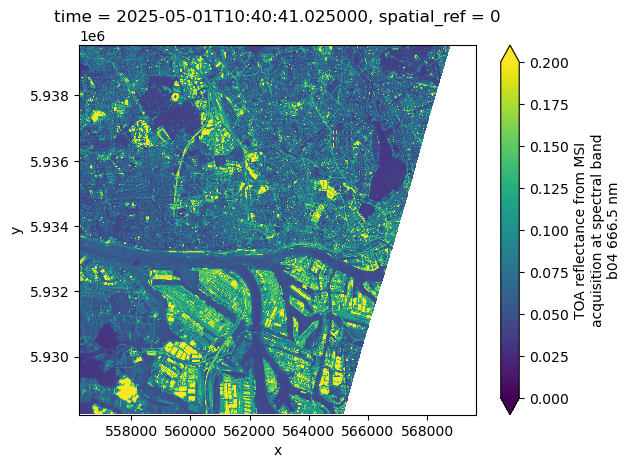

In [15]:
%%time
ds.b04.isel(time=0).plot(vmin=0, vmax=0.2)

---

(End_to_End_Example_XCUBE_EOPF)=
## End-to-End Example: Data Access, Saving, and Visulation 

In this example, we retrieve a data cube with a larger spatial extent, covering Mount Etna, and a longer time period, spanning May 2025.

Due to the increased size of this job, we limit Dask parallelization to 4 workers. This ensures a more stable and reliable process when writing the final data cube to the storage.

In [16]:
%%time
dask.config.set(scheduler="threads", num_workers=4)

bbox = [14.8, 37.45, 15.3, 37.85]
crs_utm = "EPSG:32633"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_utm)
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm,
    time_range=["2025-05-01", "2025-06-01"],
    spatial_res=20,
    crs=crs_utm,
    variables=["b02", "scl"],
)
ds

CPU times: user 6.73 s, sys: 252 ms, total: 6.98 s
Wall time: 31.8 s


<xarray.Dataset> Size: 664MB
Dimensions:      (time: 15, y: 2222, x: 2212)
Coordinates:
  * time         (time) datetime64[ns] 120B 2025-05-01T10:50:29.024000 ... 20...
    spatial_ref  int64 8B ...
  * x            (x) float64 18kB 4.823e+05 4.823e+05 ... 5.265e+05 5.265e+05
  * y            (y) float64 18kB 4.189e+06 4.189e+06 ... 4.145e+06 4.145e+06
Data variables:
    b02          (time, y, x) float64 590MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    scl          (time, y, x) uint8 74MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
Attributes: (4)

/opt/conda/lib/python3.12/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/opt/conda/lib/python3.12/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/opt/conda/lib/python3.12/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


### Saving the Data Cube

While the EOPF xcube plugin primarily facilitates data access, it also integrates smoothly with the broader xcube ecosystem for post-processing and data persistence.

To save a data cube, you can use the `memory` xcube data store for in-memory storage — ideal for small examples or demonstrations that don't require writing to disk.

💡 Note
For real-world scenarios, you’ll typically want to persist data cubes to a local filesystem or an S3-compatible object store using the file or s3 backends.

**Local Filesystem Data Store:**
```python
storage = new_data_store("file")
```
**S3 Data Store:**
```python
storage = new_data_store(
    "s3",
    root="bucket-name",
    storage_options=dict(
        anon=False,
        key="your_s3_key",
        secret="your_s3_secret",
    ),
)
```
More info: [Filesystem-based data stores](https://xcube.readthedocs.io/en/latest/dataaccess.html#filesystem-based-data-stores).


In [17]:
storage = new_data_store("memory", root="data")

We can then persist the retrieved data cube by writing it using the `storage` data store:

In [18]:
%%time
storage.write_data(ds, "sen2_etna_cube.levels", num_levels=5, replace=True)

/opt/conda/lib/python3.12/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/opt/conda/lib/python3.12/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


CPU times: user 41 s, sys: 2.31 s, total: 43.3 s
Wall time: 53.6 s


'sen2_etna_cube.levels'

This writes the final data cube in a custom multi-resolution Zarr format, referred to as the [`levels`](https://xcube.readthedocs.io/en/latest/mldatasets.html) format. It is conceptually similar to Cloud-Optimized GeoTIFF (COG) but based on Zarr layers.

The `num_levels` parameter controls how many lower-resolution levels are generated. Each additional level reduces the spatial resolution by a factor of two, which is particularly useful for efficient visualization and zooming in the xcube Viewer app.

### Visualization and Analysis

💡 **Note**  
If you are running this notebook on the [**EOPF Sample Service JupyterHub**](https://jupyterhub.user.eopf.eodc.eu/hub), please set the following environment variable to ensure the Viewer is configured with the correct endpoint.

The environment variable should be set to: `"https://jupyterhub.user.eopf.eodc.eu/user/<E-mail>/"`  
Replace `<E-mail>` with the email address you use to log in to CDSE. This corresponds to the first part of the URL displayed in your browser after logging into JupyterHub.

In [19]:
os.environ["XCUBE_JUPYTER_LAB_URL"] = (
    "https://jupyterhub.user.eopf.eodc.eu/user/konstantin.ntokas@brockmann-consult.de/"
)

Once saved as `levels` to the `storage` data store, we can open the multi-resolution datacube and open the base layer with the original resolution of 20m.  

In [20]:
mlds = storage.open_data("sen2_etna_cube.levels")
ds = mlds.get_dataset(0)
ds

<xarray.Dataset> Size: 664MB
Dimensions:      (time: 15, y: 2222, x: 2212)
Coordinates:
    spatial_ref  int64 8B ...
  * time         (time) datetime64[ns] 120B 2025-05-01T10:50:29.024000 ... 20...
  * x            (x) float64 18kB 4.823e+05 4.823e+05 ... 5.265e+05 5.265e+05
  * y            (y) float64 18kB 4.189e+06 4.189e+06 ... 4.145e+06 4.145e+06
Data variables:
    b02          (time, y, x) float64 590MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    scl          (time, y, x) uint8 74MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
Attributes: (4)

Next we use [xcube Viewer](https://xcube-dev.github.io/xcube-viewer/build_viewer/#build-and-deploy) to visualize the cube. The Viewer can be configured via a `yaml` file. The `info()` method gives the URL of the Viewer instance which can be used to open the web application. 

In [21]:
config = load_configs("server_config.yaml")
viewer = Viewer(server_config=config)
viewer.info()

Server: https://jupyterhub.user.eopf.eodc.eu/user/konstantin.ntokas@brockmann-consult.de/proxy/8000
Viewer: https://jupyterhub.user.eopf.eodc.eu/user/konstantin.ntokas@brockmann-consult.de/proxy/8000/viewer/?serverUrl=https://jupyterhub.user.eopf.eodc.eu/user/konstantin.ntokas@brockmann-consult.de/proxy/8000


404 GET /viewer/config/config.json (127.0.0.1): xcube viewer has not been been configured
404 GET /viewer/config/config.json (127.0.0.1) 5.90ms
501 GET /viewer/state?key=sentinel (127.0.0.1) 0.52ms
404 GET /viewer/ext/contributions (127.0.0.1) 136.38ms


The Viewer can also be opened within the Jupyter notebook:

In [22]:
viewer.show()

**Alternative: visualize datasets in xcube Viewer via Python API**

Alternatively, the viewer can be started via the Python API. Here, the desired data cubes are added to the viewer via the method `add_dataset()`.

In [23]:
viewer = Viewer()
viewer.add_dataset(ds)
viewer.show()

404 GET /viewer/config/config.json (127.0.0.1): xcube viewer has not been been configured
404 GET /viewer/config/config.json (127.0.0.1) 5.53ms
501 GET /viewer/state?key=sentinel (127.0.0.1) 0.63ms
404 GET /viewer/ext/contributions (127.0.0.1) 44.87ms


---

(Conclusion_XCUBE_EOPF)=
## Conclusion

This notebook demonstrates the current development status of the **xcube-eopf** data store, which adds a [data store](https://xcube.readthedocs.io/en/latest/api.html#data-store-framework) named `eopf-zarr` to the xcube framework. Below is a summary of the key takeaways:

- **3D analysis-ready spatio-temporal data cubes** can be generated from multiple EOPF Sentinel Zarr samples (currently limited to Sentinel-2).
- The cube generation workflow follows this pattern:  
  1. **Query** via the [EOPF STAC API](https://stac.browser.user.eopf.eodc.eu/)  
  2. **Read** using the [xarray-eopf backend](https://eopf-sample-service.github.io/xarray-eopf/) ([Webinar 3](https://zarr.eopf.copernicus.eu/webinars/webinar-3-access-eopf-zarr-products-with-the-new-xarray-eopf-backend/))  
  3. **Mosaic** along spatial axes  
  4. **Stack** along the time axis
- The end-to-end workflow with **xcube** includes:  
  1. Data access via the `eopf-zarr` data store  
  2. Cube persistence using writable data stores (`file`, `s3`)  
  3. Visualization using [xcube Viewer]()

---

### Future Development

- Extend support to include **Sentinel-1** and **Sentinel-3** data.
- Incorporate user feedback — please test the plugin and report issues here: 👉 [GitHub Issues – xcube-eopf](https://github.com/EOPF-Sample-Service/xcube-eopf/issues)
- Continue active development of the plugin through **January 2026**, at least within the scope of the **EOPF Sentinel Zarr Samples** project.


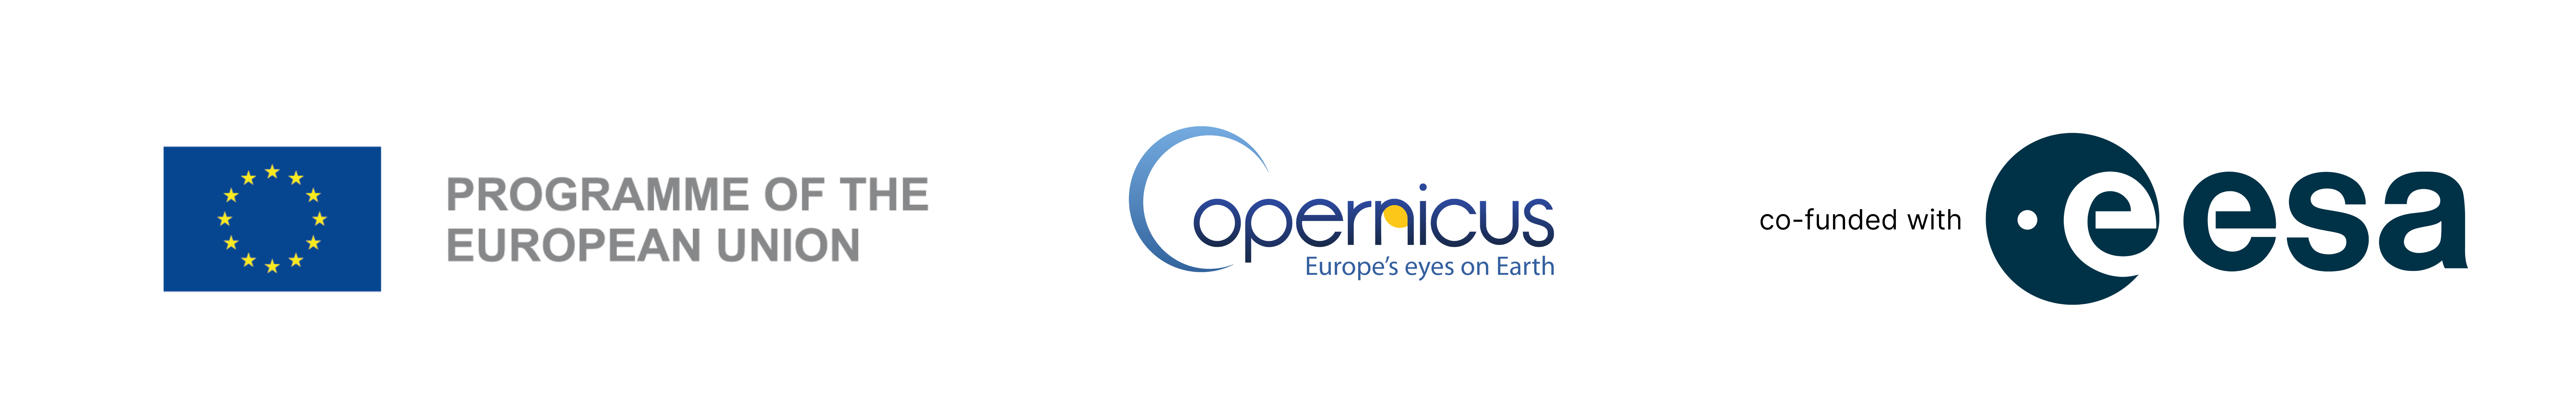